# Visualization

In [ ]:
from DiT import *

## Load the trained model

In [9]:
 # Load model:
device="cpu"
if torch.cuda.is_available():
    device="cuda:0"
seq_length=240
v=2
l_=64
repeat=0
latent_size=2
num_videos=100000
model = DiT_models[f"DiT-PD/2_N={seq_length}"](
    input_size=latent_size,
    num_classes=1000
).to(device)
# Auto-download a pre-trained model or load a custom DiT checkpoint from train.py:
ckpt_path = "./video_pts/ep49_000"+"1950"+ ".pt"
state_dict = find_model(ckpt_path)
model.load_state_dict(state_dict)
# model.eval()  
# diffusion = create_diffusion(str(1000))

ok


<All keys matched successfully>

### Load model weights

In [14]:
block_index=0
fc1=torch.abs(model.blocks[block_index].mlp.state_dict()['fc1.weight'].cpu())
fc2=torch.abs(model.blocks[block_index].mlp.state_dict()['fc2.weight'].cpu())

### Draw the heatmap of the QKV matrices

Text(0.5, 1.0, '$V$')

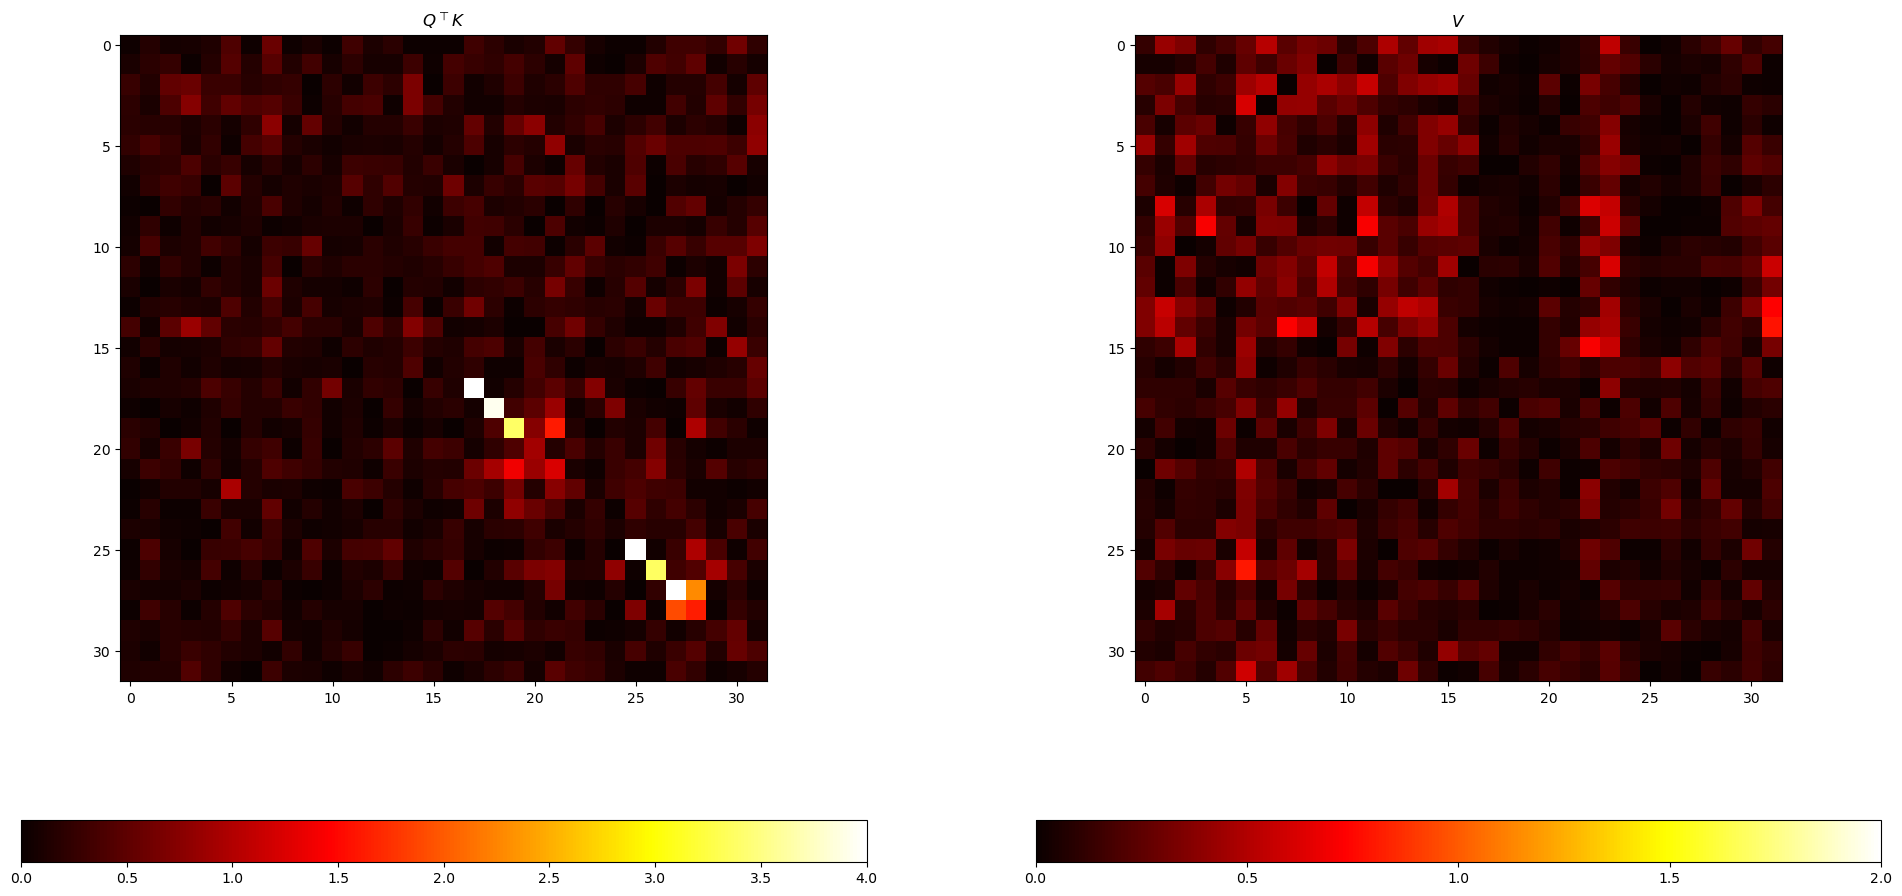

In [15]:
index=4

latent_d=32
Q=model.blocks[index].attn.qkv.state_dict()['weight'][:latent_d].cpu()
K=model.blocks[index].attn.qkv.state_dict()['weight'][latent_d:2*latent_d].cpu()
V=model.blocks[index].attn.qkv.state_dict()['weight'][2*latent_d:3*latent_d].cpu()

QK=torch.abs(Q.T@K)
V=torch.abs(V)
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
sc1=plt.imshow(QK.cpu(),cmap='hot')
sc1.set_clim(0,4)
plt.colorbar(orientation='horizontal',ticks=([0,0.5,1,1.5,2,2.5,3,3.5,4]) )
plt.title(r"$Q^{\top}K$")
plt.subplot(1,2,2)
sc2=plt.imshow(V,cmap='hot')
sc2.set_clim(0,2)
plt.colorbar(orientation='horizontal',ticks=([0,0.5,1,1.5,2,2.5]))
plt.title(r"$V$")

### Draw the attention scores along backward diffusion process

In [ ]:
from PIL import Image, ImageDraw, ImageFont
# Define font and text color
text_color = (0, 0, 0)  # White color
# List of PNG files
#record_iter=[0,1,2,4,8,16,32,64,128,256,512,999]

for j in range(12):
    images = []
    for i in record_iter:
        testit=i*12+j
        images.append(Image.open(f"./figsm/test_{testit}.png"))
        draw = ImageDraw.Draw(images[-1])
        draw.text((10, 10), f"Backward Diffusion T= {i}", fill=text_color)

    # Save the list of images as a GIF
    images[0].save(f"gifs/N=128_softmax/output_{j}.gif", save_all=True, append_images=images[1:], duration=200, loop=0)

    

    
png_files = ["image1.png", "image2.png", "image3.png"]  # 

# Open each PNG file and append it to a list
images = []
for png_file in png_files:
    images.append(Image.open(png_file))
    draw = ImageDraw.Draw(images[-1])
    draw.text((10, 10), f"Frame {i+1}", fill=text_color, font=font)

# Save the list of images as a GIF
images[0].save("output.gif", save_all=True, append_images=images[1:], duration=100, loop=0)



### Draw the (empirical) covariance matrix of the generated samples

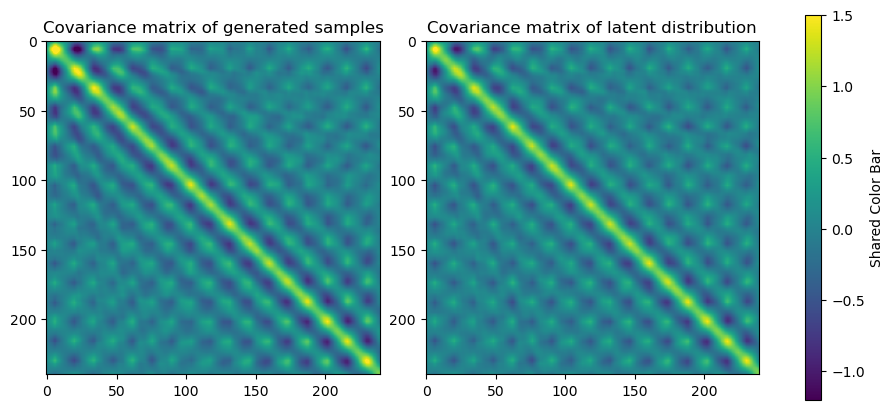

In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.gridspec as gridspec
from tqdm import tqdm

np.random.seed(66)
import numpy as np
import matplotlib.pyplot as plt


data_source = "./video_samples/sample_real-cfg0-testQKV_1000.npy"
data_source = "./video_samples/sample_real-cfg0-testQKV_99epochs_1000.npy"
data_source = "./video_samples/sample_real-cfg0-testQKV_49epochs_bounce_1000.npy"
data_source = "./video_samples/sample_real-cfg0-testQKV_49epochs_bounce_240_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-noema-cfgfixed_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-2_1000.npy"
# data_source = "/guojiawei1/video_data/data_videos_100000_cpseed66_ksqr_l8192.npy"
# 1. 加载.npy文件为数据集
data = np.load(data_source)

N, T, D=data.shape

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])


var_simple=np.cov(data[:,:,0].T)

#heat_map(var_simple,title="Samples generated by diffusion",savefig=True)

im1=ax0.imshow(var_simple, cmap='viridis',vmin=-1.2,vmax=1.5)


ax0.set_title("Covariance matrix of generated samples")

truth_latents=torch.load("./video_data/latent_data_ball_10_240_bounce.pt")
latent_x=truth_latents[:,:,0]
ax1.set_title("Covariance matrix of latent distribution")
im2=ax1.imshow(torch.cov(latent_x.T).detach().cpu(),vmin=-1.2,vmax=1.5)


# Add shared color bar
cbar = fig.colorbar(im1, cax=cax)
cbar.set_label('Shared Color Bar')

# Display the plot
plt.show()

In [42]:
from VAE import *

In [53]:
# build model
device="cpu"
num_frames=240
vae = VAE(x_dim=64*64, h_dim1= 256, h_dim2=64, z_dim=2).to(device)
if torch.cuda.is_available():
    vae=torch.load("./vae_big_ball.pt")
else:
    vae=torch.load("./vae_big_ball.pt",map_location=torch.device('cpu'))
data_source = "./video_samples/sample_real-cfg0-testQKV_99epochs_1000.npy"
#data_source = "./video_samples/sample_real-cfg0-testQKV_49epochs_bounce_1000.npy"
data_source = "./video_samples/sample_real-cfg0-testQKV_49epochs_bounce_240_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-noema-cfgfixed_1000.npy"
# data_source = "/guojiawei1/video_samples/sample_yokka-2_1000.npy"
# data_source = "/guojiawei1/video_data/data_videos_100000_cpseed66_ksqr_l8192.npy"
# 1. 加载.npy文件为数据集
data = np.load(data_source)

for _ in [777]:
    frames=[]
    sample_index=_
    latent_representations=data[sample_index]
    gif_filename=f"sampled_latents_{sample_index}.gif"
    
    for i in range(num_frames):
        latent=latent_representations[i]
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    
        # Plot latent representation
        axs[1].plot(latent_representations[:i, 0], latent_representations[:i, 1], marker='o', linestyle='-', color='b', alpha=0.3)
        #axs[1].scatter(latent[0], latent[1], color='r')
        axs[1].set_title('Latent Space')
        axs[1].set_xlabel('Latent Dimension 1')
        axs[1].set_ylabel('Latent Dimension 2')
        axs[1].set_xlim(-3,3)
        axs[1].set_ylim(-3,3)
        axs[1].grid(True)
    
        axs[0].imshow(vae.decoder(torch.tensor(latent.reshape(1,-1)).to(device)).reshape(64,64).detach().cpu())
        axs[0].set_title(f'Diffusion Samples Frame {i}')
        axs[0].axis('off')
    
        
    
        # Save the plot as a frame
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
    
        plt.close(fig)
    
    # Create a GIF
    imageio.mimsave(gif_filename, frames, format='GIF', duration=0.1)




/var/folders/lc/jc6z9jpd0rl9lr56wxtvgzl80000gn/T/ipykernel_15094/1283195954.py:47: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
